# Projet - Detection d'URLs malicieuses à l'aide du machine learning (PySpark)

Auteurs : Quentin PAUWELS & Samuel ISRAEL

In [1]:
# Importations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from pyspark import SparkConf
from pyspark.sql import SparkSession, functions

from pyspark.sql.types import ArrayType, StringType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Importations des modèles
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.classification import RandomForestClassifier

In [2]:
# Initialisation SparkSession

conf = SparkConf()
#conf.set("spark.broadcast.blockSize", 4096)
conf.set("spark.cores.max", "8")
conf.set("spark.driver.memory","8g")

# Créer un objet SparkSession
spark = SparkSession.builder.config(conf=conf).appName("MyApp").getOrCreate()

22/12/13 08:40:58 WARN Utils: Your hostname, quentin resolves to a loopback address: 127.0.1.1; using 192.168.2.132 instead (on interface wlp0s20f3)
22/12/13 08:40:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/13 08:40:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Chargement du dataset

In [3]:
# Chargement des donnees

# Charger les données à partir d'un fichier CSV
data = spark.read.csv("urldata.csv", header=True, inferSchema=True)

data = data.select(["URLs", "Class"])

# Remplace le terme 'benign' par 0, le reste par 1
data = data.withColumn("Class", functions.when(data["Class"] == "benign", 0)
                                         .otherwise(1))

### Ajout de critères au dataset

In [4]:
from pyspark.sql import functions as F

data = data.withColumn("url_length", F.length("URLs"))
data = data.withColumn("count-dir", F.size(F.split(F.col("URLs"), r"/")) - 3)
data = data.withColumn("count-digits", F.size(F.split(F.col("URLs"), r"\d")) - 1)
data = data.withColumn("count-points", F.size(F.split(F.col("URLs"), r"\.")) - 1)
data = data.withColumn("count-", F.size(F.split(F.col("URLs"), r"\-")) - 1)
data = data.withColumn("count_", F.size(F.split(F.col("URLs"), r"\_")) - 1)
data = data.withColumn("count@", F.size(F.split(F.col("URLs"), r"\@")) - 1)
data = data.withColumn("count?", F.size(F.split(F.col("URLs"), r"\?")) - 1)
data = data.withColumn("count%", F.size(F.split(F.col("URLs"), r"\%")) - 1)
data = data.withColumn("count=", F.size(F.split(F.col("URLs"), r"\=")) - 1)
data = data.withColumn("count-http", F.size(F.split(F.col("URLs"), r"http")) - 1)
data = data.withColumn("count-https", F.size(F.split(F.col("URLs"), r"https")) - 1)
data = data.withColumn("count-www", F.size(F.split(F.col("URLs"), r"www")) - 1)

data.show(truncate=False)

+-------------------------+-----+----------+---------+------------+------------+------+------+------+------+------+------+----------+-----------+---------+
|URLs                     |Class|url_length|count-dir|count-digits|count-points|count-|count_|count@|count?|count%|count=|count-http|count-https|count-www|
+-------------------------+-----+----------+---------+------------+------------+------+------+------+------+------+------+----------+-----------+---------+
|https://www.google.com   |0    |22        |0        |0           |2           |0     |0     |0     |0     |0     |0     |1         |1          |1        |
|https://www.youtube.com  |0    |23        |0        |0           |2           |0     |0     |0     |0     |0     |0     |1         |1          |1        |
|https://www.facebook.com |0    |24        |0        |0           |2           |0     |0     |0     |0     |0     |0     |1         |1          |1        |
|https://www.baidu.com    |0    |21        |0        |0         

#### Mise en place de fonctions pratiques pour la suite

In [5]:
def trainModel(pipeline, train_data):
    # Entraîner le modèle sur les données d'entrée
    model = pipeline.fit(train_data)
    return model

def results(model, test_data):
    # Utiliser le modèle entraîné pour prédire des étiquettes de sortie pour les données de test
    predictions = model.transform(test_data)

    # Définir les paramètres d'évaluation du modèle
    evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")

    # Évaluer le modèle en utilisant les données d'entrée et les étiquettes de sortie prédites
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print("RECALL :", evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))

    return (accuracy, f1, predictions)

def printResults(accuracy, f1, predictions):
    # Afficher l'accuracy du modèle
    print("Accuracy : ", accuracy)
    print("Score F1 : ", f1)

    # Afficher la matrice de confusion
    predictions.groupBy("Class", "prediction").count().show()

    #predictions.select("Class", "prediction").show()

#### Division du dataset en un dataset d'entrainement et un de test

In [6]:
# Diviser les données en deux ensembles aléatoires
train_data, test_data = data.randomSplit([0.8, 0.2])
train_data_token, test_data_token = data.randomSplit([0.8, 0.2])

# Afficher le nombre de partitions utilisées pour distribuer les données
num_partitions = train_data.rdd.getNumPartitions()
print("Il y a ", num_partitions, " partitions utilisées")

Il y a  9  partitions utilisées


## Sans l'utilisation de tokenizer

In [7]:
input_cols = ['count-digits',
                'count-dir',
                'count-points',
                'count-',
                'count_',
                'count@',
                'count?',
                'count%',
                'count=',
                'count-http',
                'count-https',
                'count-www',
                'url_length'
                ]

# Sélectionner les colonnes input_cols comme entrées pour le modèle
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

### Modele : NaiveBayes

In [8]:
# Créer un objet NaiveBayes
mnb = NaiveBayes(labelCol="Class", featuresCol="features")

# Combiner les étapes d'assemblage des vecteurs et de NaiveBayes en un seul pipeline
pipeline = Pipeline(stages=[assembler, mnb])

try:
    model = trainModel(pipeline, train_data)
    accuracy_mnb, f1_mnb, predictions = results(model, test_data)
    printResults(accuracy_mnb, f1_mnb, predictions)
except:
    accuracy_mnb, f1_mnb = 0, 0

22/12/13 08:41:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/12/13 08:41:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/13 08:41:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


RECALL : 0.8149081622411313
Accuracy :  0.8149081622411313
Score F1 :  0.7932093131527804


+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|65465|
|    0|       1.0| 3544|
|    1|       0.0|13053|
|    1|       1.0| 7607|
+-----+----------+-----+



### Modele : Regression Logistique

In [9]:
# Créer un objet LogisticRegression
lr = LogisticRegression(labelCol="Class", featuresCol="features", maxIter=150, regParam=0.1)

# Combiner les étapes d'assemblage des vecteurs et de régression logistique en un seul pipeline
pipeline = Pipeline(stages=[assembler, lr])

model = trainModel(pipeline, train_data)
accuracy_lr, f1_lr, predictions = results(model, test_data)
printResults(accuracy_lr, f1_lr, predictions)

RECALL : 0.962785355027936
Accuracy :  0.962785355027936
Score F1 :  0.9615906830547243


+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|69008|
|    0|       1.0|    1|
|    1|       0.0| 3336|
|    1|       1.0|17324|
+-----+----------+-----+



### Modele : RandomForest

In [10]:
# Créer un objet RandomForestClassifier
rfc = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Combiner les étapes d'assemblage des vecteurs et de randomForest en un seul pipeline
pipeline = Pipeline(stages=[assembler, rfc])

model = trainModel(pipeline, train_data)
accuracy_rfc, f1_rfc, predictions = results(model, test_data)
printResults(accuracy_rfc, f1_rfc, predictions)

RECALL : 0.9968662525510489
Accuracy :  0.9968662525510489
Score F1 :  0.9968653214524574


+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|68886|
|    0|       1.0|  123|
|    1|       0.0|  158|
|    1|       1.0|20502|
+-----+----------+-----+



## Avec l'utilisation d'un tokenizer

### Définition et application du tokenizer

In [11]:
# Definition du tokenizer
def my_tokenizer(url): 
  # Split by slash (/) and dash (-)
  tokens = re.split('[/-]', url)
  for i in tokens:   
    # Include the splits extensions and subdomains
    if i.find(".") >= 0:
      dot_split = i.split('.')
      # Remove .com and www. since they're too common
      if "com" in dot_split:
        dot_split.remove("com")
      if "www" in dot_split:
        dot_split.remove("www")
      
      tokens += dot_split
    
    try: 
      while(tokens.index('')):
        tokens.remove('')
    except:
        pass
  return tokens

udf = functions.UserDefinedFunction(my_tokenizer, returnType=ArrayType(StringType()))

# Application de la fonction my_tokenizer à la colonne URLs 
output_column_train = udf(train_data["URLs"])
output_column_test = udf(test_data["URLs"])

train_data = train_data.withColumn("tokens", output_column_train)
test_data = train_data.withColumn("tokens", output_column_test)

train_data = train_data.select("URLs", "Class", "tokens")
test_data = test_data.select("URLs", "Class", "tokens")

train_data.show(truncate=False)

+--------------------------+-----+-------------------------------------------+
|URLs                      |Class|tokens                                     |
+--------------------------+-----+-------------------------------------------+
|https://www.0123movies.com|0    |[https:, www.0123movies.com, 0123movies]   |
|https://www.01net.com     |0    |[https:, www.01net.com, 01net]             |
|https://www.1111.com.tw   |0    |[https:, www.1111.com.tw, 1111, tw]        |
|https://www.114la.com     |0    |[https:, www.114la.com, 114la]             |
|https://www.11st.co.kr    |0    |[https:, www.11st.co.kr, 11st, co, kr]     |
|https://www.123rf.com     |0    |[https:, www.123rf.com, 123rf]             |
|https://www.126.com       |0    |[https:, www.126.com, 126]                 |
|https://www.163.com       |0    |[https:, www.163.com, 163]                 |
|https://www.1688.com      |0    |[https:, www.1688.com, 1688]               |
|https://www.17ok.com      |0    |[https:, www.17ok.

### Creation de l'object CountVectorizer

In [12]:
# Créer un objet CountVectorizer
counter = CountVectorizer(inputCol="tokens", outputCol="features")

### Modele : NaiveBayes

In [13]:
# Créer un objet NaiveBayes
mnb = NaiveBayes(labelCol="Class", featuresCol="features")

# Combiner les étapes de CountVectorizer et de NaiveBayes en un seul pipeline
pipeline = Pipeline(stages=[counter, mnb])

model = trainModel(pipeline, train_data)
accuracy_mnb_token, f1_mnb_token, predictions = results(model, test_data)
printResults(accuracy_mnb_token, f1_mnb_token, predictions)

22/12/13 08:42:13 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:20 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/12/13 08:42:24 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/12/13 08:42:28 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


RECALL : 0.9967989525862189
Accuracy :  0.9967989525862189
Score F1 :  0.9967962247972366
22/12/13 08:42:33 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/12/13 08:42:37 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    0|       0.0|276356|
|    0|       1.0|   373|
|    1|       0.0|   781|
|    1|       1.0| 82997|
+-----+----------+------+



### Modele : Regression Logistique

In [14]:
# Créer un objet LogisticRegression
lr = LogisticRegression(labelCol="Class", featuresCol="features", maxIter=150, regParam=0.1)

# Combiner les étapes de CountVectorizer et de régression logistique en un seul pipeline
pipeline = Pipeline(stages=[counter, lr])

model = trainModel(pipeline, train_data)
accuracy_lr_token, f1_lr_token, predictions = results(model, test_data)
printResults(accuracy_lr_token, f1_lr_token, predictions)

22/12/13 08:42:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:42:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/13 08:42:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/12/13 08:42:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:42:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:42:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:42:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:42:59 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:42:59 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:00 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:00 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:02 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:08 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:11 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:12 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:12 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:13 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:14 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:14 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:16 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:17 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:17 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:22 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:43:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:31 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/12/13 08:43:33 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/12/13 08:43:38 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/12/13 08:43:42 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


RECALL : 0.9938586490692274
Accuracy :  0.9938586490692275
Score F1 :  0.9938297927368
22/12/13 08:43:46 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/12/13 08:43:51 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
+-----+----------+------+
|Class|prediction| count|
+-----+----------+------+
|    0|       0.0|276728|
|    0|       1.0|     1|
|    1|       0.0|  2213|
|    1|       1.0| 81565|
+-----+----------+------+



### Modele : RandomForest

In [15]:
# Créer un objet RandomForestClassifier
rfc = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Combiner les étapes de CountVectorizer et de randomForest en un seul pipeline
pipeline = Pipeline(stages=[counter, rfc])

try:
    model = trainModel(pipeline, train_data)
    accuracy_rfc_token, f1_rfc_token, predictions = results(model, test_data)
    printResults(accuracy_rfc_token, f1_rfc_token, predictions)
except:
    accuracy_rfc_token, f1_rfc_token = 0, 0

22/12/13 08:44:02 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:44:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/12/13 08:44:07 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/12/13 08:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


22/12/13 08:44:49 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/12/13 08:45:03 WARN BlockManager: Block rdd_630_4 could not be removed as it was not found on disk or in memory
22/12/13 08:45:03 WARN BlockManager: Block rdd_630_0 could not be removed as it was not found on disk or in memory
22/12/13 08:45:03 ERROR Executor: Exception in task 4.0 in stage 173.0 (TID 1096)
java.lang.OutOfMemoryError: Java heap space: failed reallocation of scalar replaced objects
22/12/13 08:45:03 ERROR Executor: Exception in task 0.0 in stage 173.0 (TID 1092)
java.lang.OutOfMemoryError: Java heap space
22/12/13 08:45:03 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[Executor task launch worker for task 4.0 in stage 173.0 (TID 1096),5,main]
java.lang.OutOfMemoryError: Java heap space: failed reallocation of scalar replaced objects
22/12/13 08:45:03 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[Executor task launch worker for task 0.0 in stage 173.0 (TID 1092),5,main]
java.lang.OutOfMemoryError: Java heap space
22

Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.status.LiveStage.toApi(LiveEntity.scala:521)
	at org.apache.spark.status.AppStatusListener.$anonfun$activeStages$3(AppStatusListener.scala:1040)
	at org.apache.spark.status.AppStatusListener$$Lambda$685/0x00000008405b8040.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$129/0x0000000840221040.apply(Unknown Source)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.immutable.List.map(List.scala:305)
	at org.apache.spark.status.AppStatusListener.activeStages(AppStatusListener.scala:1040)
	at org.apache.spark.status.AppStatusStore.$anonfun$activeStages$1(AppStatusStore.scala:164)
	at org.apache.spark.status.AppStatusStore$$Lamb

## Comparaison graphiques des différentes techniques

22/12/13 08:45:03 WARN BlockManager: Putting block rdd_630_5 failed due to exception org.apache.spark.TaskKilledException.
===== Comparaisons graphiques avec Tokenizer =====
22/12/13 08:45:03 ERROR Utils: Uncaught exception in thread Executor task launch worker for task 5.0 in stage 173.0 (TID 1097)
java.lang.NullPointerException
	at org.apache.spark.scheduler.Task.$anonfun$run$3(Task.scala:157)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1484)
	at org.apache.spark.scheduler.Task.run(Task.scala:155)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
22/12

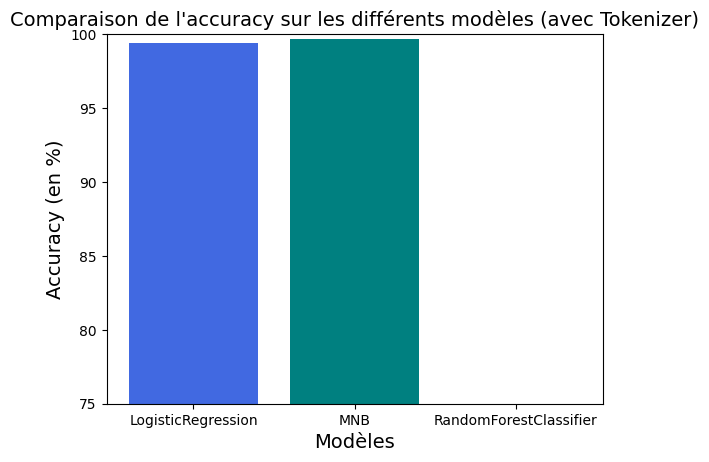

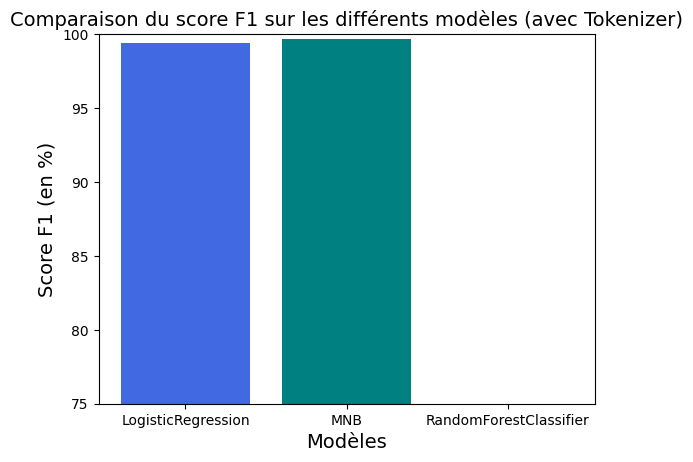

In [16]:
print("===== Comparaisons graphiques avec Tokenizer =====")

labels = ["LogisticRegression", "MNB", "RandomForestClassifier"]

# Accuracy
scores = [accuracy_lr_token, accuracy_mnb_token, accuracy_rfc_token]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison de l'accuracy sur les différents modèles (avec Tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Accuracy (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

# F1 score
scores = [f1_lr_token, f1_mnb_token, f1_rfc_token]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison du score F1 sur les différents modèles (avec Tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Score F1 (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

===== Comparaisons graphiques sans tokenizer =====


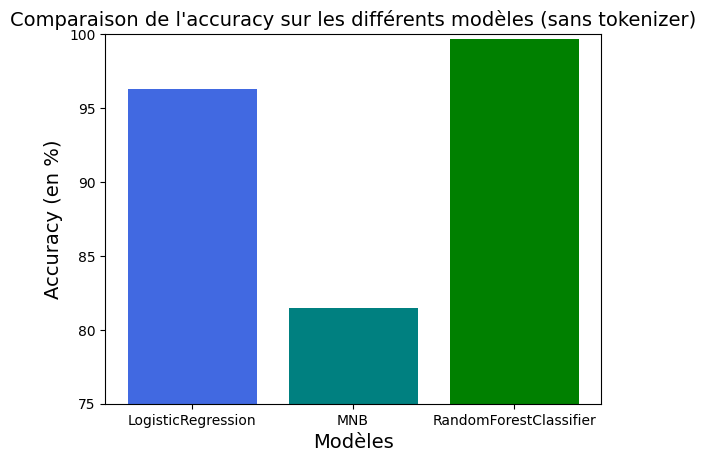

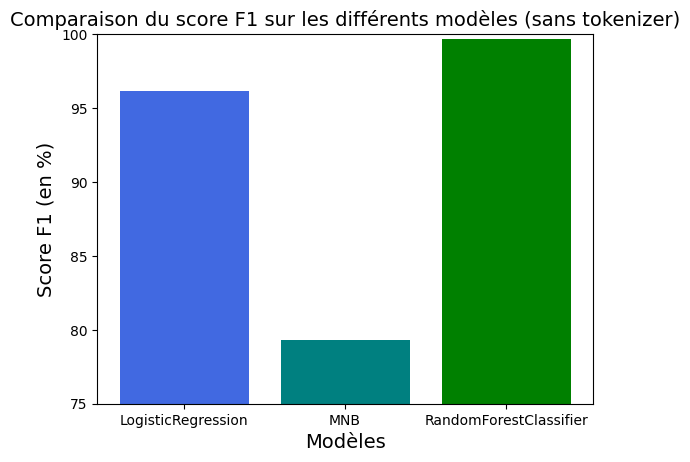

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 42004)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/quentin/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/quentin/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/quentin/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates =

In [17]:
print("===== Comparaisons graphiques sans tokenizer =====")

labels = ["LogisticRegression", "MNB", "RandomForestClassifier"]

# Accuracy
scores = [accuracy_lr, accuracy_mnb, accuracy_rfc]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison de l'accuracy sur les différents modèles (sans tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Accuracy (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

# F1_score
scores = [f1_lr, f1_mnb, f1_rfc]
scores = [score * 100 for score in scores]
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison du score F1 sur les différents modèles (sans tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Score F1 (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()